# Telecomunicaciones: identificar operadores ineficaces
**Objetivo:** Identificar los operadores menos eficacez del servicio de telefonía virtual CallMeMayb.

Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia

## Cargas el datset

In [1]:
#Importar librerias
import pandas as pd
from datetime import datetime 
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

In [2]:
# Lectura de los datos
data = pd.read_csv('/datasets/telecom_dataset_us.csv')
df_clientes = pd.read_csv('/datasets/telecom_clients_us.csv')

#Información general
data.info()

#Verificación de datos duplicados 
data.duplicated().sum()
df_clientes.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


0

## Preprosesamiento de los datos

In [3]:
#Información general
data.info()
df_clientes.info()

#Las primeras 5 filas de los datset
data.head()
df_clientes.head()

#Verificación de datos duplicados 
data.duplicated().sum()
df_clientes.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2 

0

In [4]:
data['user_id'].nunique(), data[data.duplicated()]['user_id'].nunique()

(307, 269)

In [5]:
data[data['user_id'] == 166377].head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5


In [6]:
# Verificar valores ausentes
data.isna().sum()

# Convertir al tipo de dato deseado
#el objeto datetime con zona horaria 
data['date'] = datetime.strptime('2019-08-04 00:00:00+03:00', '%Y-%m-%d %H:%M:%S%z')
df_clientes['date_start'] = pd.to_datetime(df_clientes['date_start'])

#Eliminamos duplicados
data = data.drop_duplicates()



## Analisis exploratorio de los datos


**TENER EN CUENTA** un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes.

Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

### Descripción de los datos

In [7]:
#dataset para llamadas entrantes
call_in = data[data['direction'] == 'in']
call_in['is_missed_call'].value_counts()

#dataset para llamadas salientes
call_out = data[data['direction'] == 'out']
call_out['is_missed_call'].value_counts()

#Añadir la columna fecha al dataset
call_in['fecha'] = call_in['date'].dt.date

#Descripcion de los datos
call_in.describe()

/tmp/ipykernel_50/4002528891.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_in['fecha'] = call_in['date'].dt.date


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,18996.000000,12677.000000,18996.000000,18996.000000,18996.000000
mean,167286.839545,916640.924036,10.331333,518.274742,649.035850
std,584.586453,20210.296646,52.756197,1352.130541,1518.662291
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166833.000000,901178.000000,1.000000,0.000000,45.000000
50%,167158.000000,913788.000000,3.000000,69.000000,162.000000
75%,167799.000000,936984.000000,7.000000,479.000000,635.000000
max,168606.000000,973286.000000,2168.000000,33897.000000,42667.000000


In [8]:
call_in['operator_id'].nunique(), data['operator_id'].nunique()

(754, 1092)

### Visualizar las distribuciones: Mediante histogramas y graficos de dispersion, llamadas perdidas, duracion de la llamada y tiempo de espera

In [9]:
call_in.head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,fecha
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2019-08-04
7,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,6,0,35,2019-08-04


<AxesSubplot:>

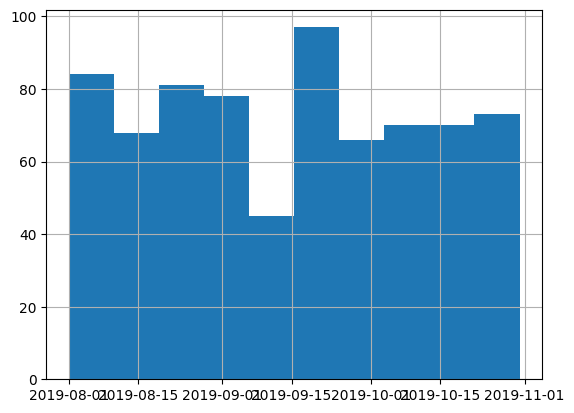

In [10]:
df_clientes['date_start'].hist()

In [11]:
df_clientes['date_start'].min(), df_clientes['date_start'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-10-31 00:00:00'))

In [12]:
print('Usuarios unicos en los dataset clientes y data', df_clientes['user_id'].nunique(), data['user_id'].nunique())

Usuarios unicos en los dataset clientes y data 732 307


In [13]:
data['operator_id'].nunique()

1092

In [14]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-04 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-04 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-04 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-04 00:00:00+03:00,out,False,880022.0,True,3,0,25


**Estamos manejando datos de un solo dia en data y de dos meses en df_clientes**

In [64]:
#Cantidad de llamadas perdidas
data['is_missed_call'].value_counts()

False    27522
True     19675
Name: is_missed_call, dtype: int64

**Conclusion:** Mas llamdas contestadas que perdidas

(0, 46474, 300.818526601267)

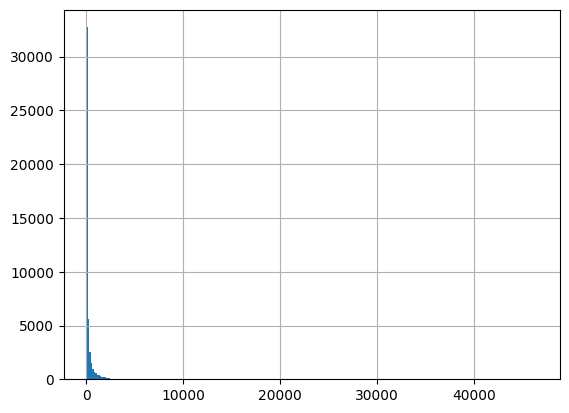

In [16]:
# Distribucion de los tiempos de espera

data['tiempo_espera'] = data['total_call_duration'] - data['call_duration']
data['tiempo_espera'].hist(bins=300)
data['tiempo_espera'].min(), data['tiempo_espera'].max(), data['tiempo_espera'].mean()

<AxesSubplot:xlabel='tiempo_espera', ylabel='Count'>

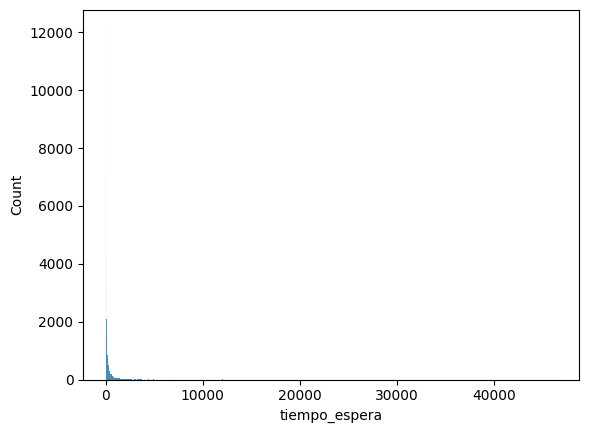

In [17]:
sns.histplot(data=data, x="tiempo_espera", binwidth=20)

### Correlacion entre las variables 

<AxesSubplot:>

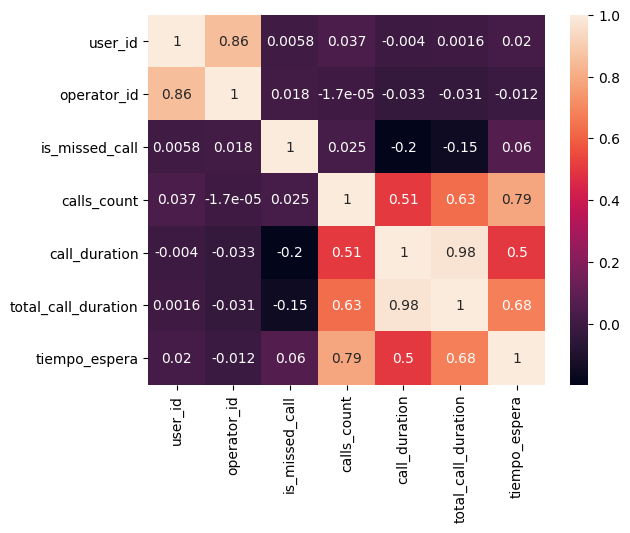

In [18]:
corr = data.corr()
sns.heatmap(corr, annot=True, )

**Conclusion:** 
- Existe una fuerte correlacion positiva entre el numero de llamadas y la duracion de la llamada
- Cuando la duracion de la llamda aumenta, el tiempo de espera tambien. 
pero se identifica una mayor correlacion entre la cantidad de llamdas y el tiempo de espera.

### calcular la proporción de clientes por operadores.

**Para llamadas entrantes**

In [19]:
#dataset para llamadas entrantes
call_in = data[data['direction'] == 'in']
call_in['is_missed_call'].value_counts()

False    12103
True      6893
Name: is_missed_call, dtype: int64

In [20]:
#dataset para llamadas salientes
call_out = data[data['direction'] == 'out']
call_out['is_missed_call'].value_counts()

False    15419
True     12782
Name: is_missed_call, dtype: int64

In [21]:
data['direction'].value_counts()

out    28201
in     18996
Name: direction, dtype: int64

In [22]:
# Contar el número de clientes por operador
customer_count = data['operator_id'].value_counts()

# Calcular la proporción de clientes por operador
customer_proportion = customer_count / customer_count.sum()

print("Número de clientes por operador:")
print(customer_count)

print("\nProporción de clientes por operador:")
print(customer_proportion)

Número de clientes por operador:
901884.0    309
901880.0    283
885876.0    279
893804.0    271
887276.0    259
           ... 
930692.0      1
956664.0      1
905478.0      1
932246.0      1
891250.0      1
Name: operator_id, Length: 1092, dtype: int64

Proporción de clientes por operador:
901884.0    0.007584
901880.0    0.006946
885876.0    0.006848
893804.0    0.006652
887276.0    0.006357
              ...   
930692.0    0.000025
956664.0    0.000025
905478.0    0.000025
932246.0    0.000025
891250.0    0.000025
Name: operator_id, Length: 1092, dtype: float64


In [24]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tiempo_espera
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,4
1,166377,2019-08-04 00:00:00+03:00,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-04 00:00:00+03:00,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-04 00:00:00+03:00,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-04 00:00:00+03:00,out,False,880022.0,True,3,0,25,25


### Dispersion de la cantidad de llamadas

(array([4.6103e+04, 6.6800e+02, 1.1200e+02, 7.5000e+01, 6.0000e+01,
        5.8000e+01, 4.0000e+01, 2.2000e+01, 1.0000e+01, 7.0000e+00,
        1.0000e+01, 8.0000e+00, 5.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 9.73200e+01, 1.93640e+02, 2.89960e+02, 3.86280e+02,
        4.82600e+02, 5.78920e+02, 6.75240e+02, 7.71560e+02, 8.67880e+02,
        9.64200e+02, 1.06052e+03, 1.15684e+03, 1.25316e+03, 1.34948e+03,
        1.44580e+03, 1.54212e+03, 1.63844e+03, 1.73476e+03, 1.83108e+03,
        1.92740e+03, 2.023

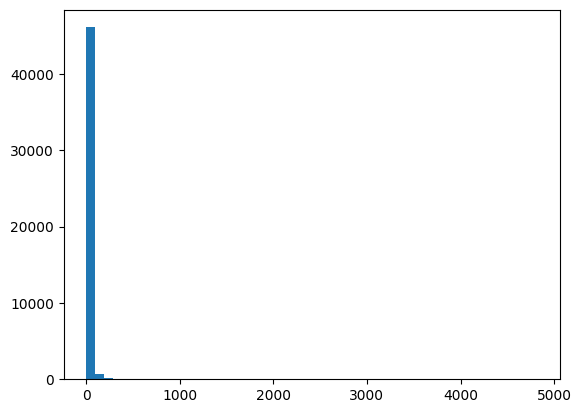

In [25]:
#Diagrama de dispersion
plt.hist(data['calls_count'], bins=50)

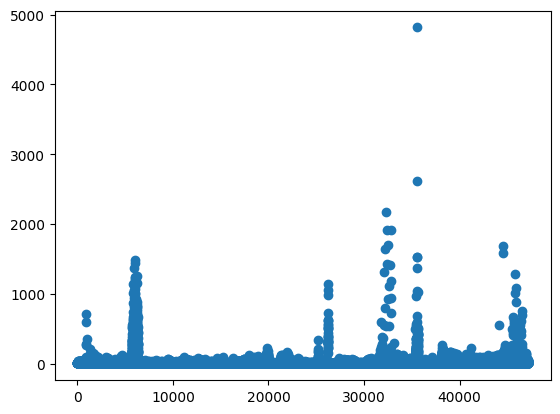

In [26]:
x_values = pd.Series(range(0, len(data['calls_count'])))
plt.scatter(x_values, data['calls_count'])

In [27]:
print(np.percentile(data['calls_count'], [50, 95, 99]))

[  4.  64. 171.]


No más del 5% de los usuarios realizaron mas 64 llamadas y no más del 1% más de $171.

el promedio es de 17

### calcular los percentiles(95,99), para identificar el tiempo atipico de espera, y el numero de llamadas salientes y perdidas

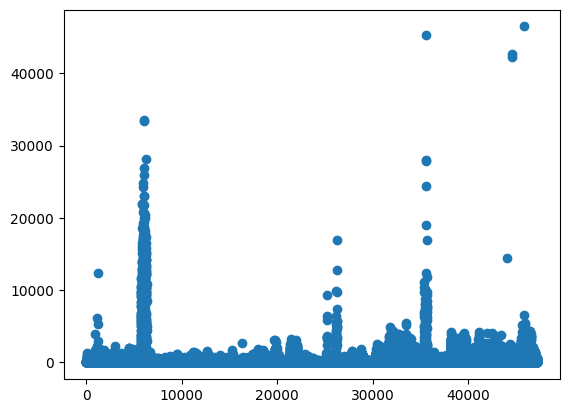

In [28]:
x_value = pd.Series(range(0, len(data['tiempo_espera'])))
plt.scatter(x_value, data['tiempo_espera'])

In [29]:
print(np.percentile(data['tiempo_espera'], [50, 95, 99]))

[  59.   1200.   3270.24]


**Conclusion:**

In [30]:
data.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,tiempo_espera
count,47197.000000,40742.000000,47197.000000,47197.000000,47197.000000,47197.000000
mean,167299.450050,916658.887634,17.032799,899.392504,1200.211030,300.818527
std,599.003852,21243.446041,64.740154,3843.152137,4530.085895,1152.272269
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,0.000000
25%,166800.000000,900826.000000,2.000000,0.000000,55.000000,19.000000
50%,167172.000000,914010.000000,4.000000,51.000000,232.000000,59.000000
75%,167827.000000,937732.000000,13.000000,612.000000,951.000000,211.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000,46474.000000


In [31]:
# dataset solo para llamdas entrantes perdidas
call_in_per = call_in[call_in['is_missed_call'] == True]
call_in_per.isna().sum()

user_id                   0
date                      0
direction                 0
internal                 49
operator_id            6251
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
tiempo_espera             0
dtype: int64

**Conclusion:** Las llamadas entrantes perdidas, son 6893 de las cuales 6251 no tienen un operador asignado lo que se da a entender que la mayoria de llamdas perdidas entrantes es por que no se le asigna un operador

In [ ]:
Con las 642 llamadas entrantes perdidas, con operador asignado vamos a trabajar.

In [65]:
# Determinar la cantidad de llamadas entrantes perdidas para cada operador 

llamad_entr_perdidas = (
    call_in_per.drop(['user_id', 'date', 'direction', 'internal', 'is_missed_call', 'total_call_duration', 'tiempo_espera'], axis=1)
    .groupby('operator_id', as_index=False)
    .agg({'calls_count': 'sum'})
)

llamad_entr_perdidas.columns = ['operador_id', 'cant_llamadas_perd']


(array([199.,  20.,   6.,   7.,   4.,   0.,   2.,   0.,   0.,   1.]),
 array([ 1. ,  5.5, 10. , 14.5, 19. , 23.5, 28. , 32.5, 37. , 41.5, 46. ]),
 <BarContainer object of 10 artists>)

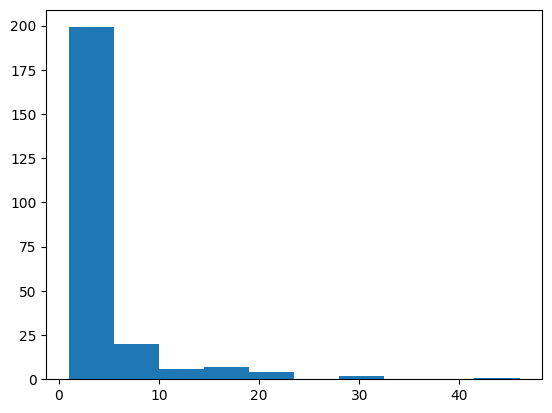

In [66]:
plt.hist(llamad_entr_perdidas['cant_llamadas_perd'])

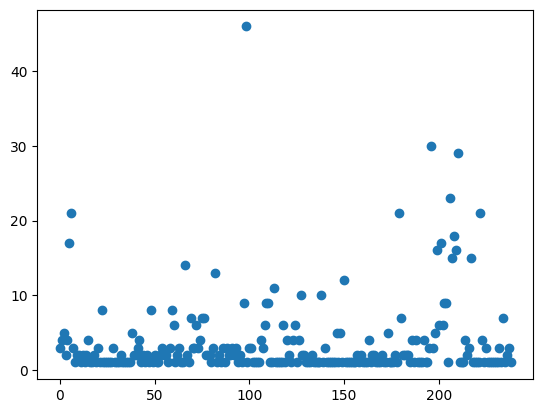

In [67]:
#Diagrama de dispersion para las llamadas perdidas
x_valu = pd.Series(range(0,len(llamad_entr_perdidas)))

plt.scatter(x_valu, llamad_entr_perdidas['cant_llamadas_perd'])

In [68]:
print(np.percentile(llamad_entr_perdidas['cant_llamadas_perd'], [90, 95, 99]))

[ 9.   15.1  26.72]


**Conclusion:** Determinamos que los operadores con mas de 15 llamadas perdidas, se consideraran ineficaces.

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

El análisis de la proporción de clientes por operador y la distribución de las llamadas perdidas está bien planteado, pero hay un error significativo en el uso de los gráficos de dispersión. Estos gráficos deben utilizarse para mostrar la relación entre dos variables continuas, mientras que aquí estás usando el índice del registro como el eje X, lo cual no tiene relevancia analítica. Esto puede llevar a interpretaciones incorrectas.

Te sugiero que sustituyas estos gráficos por opciones más apropiadas, como histogramas o diagramas de caja, que permitirán visualizar mejor la distribución de las llamadas perdidas o el tiempo de espera por operador. De esta manera, tu análisis será más preciso y comprensible.

¡Sigue adelante y ajusta las visualizaciones para que reflejen mejor tus hallazgos!
</div>


### Identificar operadores ineficientes en cuando al tiempo de espera y calcular percentiles

In [34]:
#Filtramos para llamadas entrantes contestadas

call_in_conts = call_in[call_in['is_missed_call'] == False]
call_in_conts.isna().sum()

user_id                 0
date                    0
direction               0
internal               54
operator_id            68
is_missed_call          0
calls_count             0
call_duration           0
total_call_duration     0
tiempo_espera           0
dtype: int64

In [35]:
call_in_conts[call_in_conts.isnull().any(axis=1)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tiempo_espera
698,166399,2019-08-04 00:00:00+03:00,in,False,NaN,False,1,10,55,45
704,166399,2019-08-04 00:00:00+03:00,in,False,NaN,False,1,68,115,47
1924,166406,2019-08-04 00:00:00+03:00,in,NaN,879898.0,False,1,2,9,7
4136,166503,2019-08-04 00:00:00+03:00,in,False,NaN,False,1,374,405,31
6210,166541,2019-08-04 00:00:00+03:00,in,NaN,908960.0,False,1,393,423,30
...,...,...,...,...,...,...,...,...,...,...
50946,168252,2019-08-04 00:00:00+03:00,in,False,NaN,False,45,23765,23897,132
51021,168253,2019-08-04 00:00:00+03:00,in,NaN,952948.0,False,2,61,63,2
51505,168307,2019-08-04 00:00:00+03:00,in,NaN,945046.0,False,1,745,748,3
51680,168336,2019-08-04 00:00:00+03:00,in,False,NaN,False,1,169,174,5


In [36]:
callByOperation = (
    call_in_conts.drop(['user_id', 'date', 'direction', 'internal', 'is_missed_call', 'total_call_duration'], axis=1)
    .groupby('operator_id', as_index=False)
    .agg({'tiempo_espera': 'sum', 'calls_count': 'sum'})
)

callByOperation.columns = ['operador_id', 'tiempo_espera', 'cantidad_llamadas']

print(callByOperation.sort_values(by='tiempo_espera', ascending=False))

     operador_id  tiempo_espera  cantidad_llamadas
335     919790.0          52875               1578
288     913938.0          40413               4752
334     919554.0          37848               1171
333     919552.0          37022               1088
445     931458.0          35049               2066
..           ...            ...                ...
662     952114.0              3                  1
64      891948.0              3                  1
674     952954.0              2                  2
582     940828.0              2                  1
636     948282.0              1                  1

[753 rows x 3 columns]


(array([696.,  35.,  10.,   2.,   2.,   1.,   3.,   3.,   0.,   1.]),
 array([1.00000e+00, 5.28840e+03, 1.05758e+04, 1.58632e+04, 2.11506e+04,
        2.64380e+04, 3.17254e+04, 3.70128e+04, 4.23002e+04, 4.75876e+04,
        5.28750e+04]),
 <BarContainer object of 10 artists>)

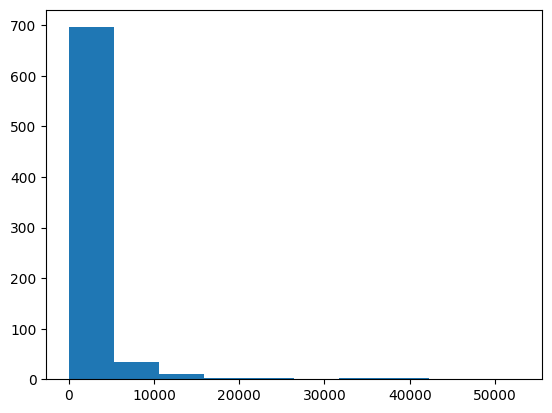

In [37]:
plt.hist(callByOperation['tiempo_espera'])

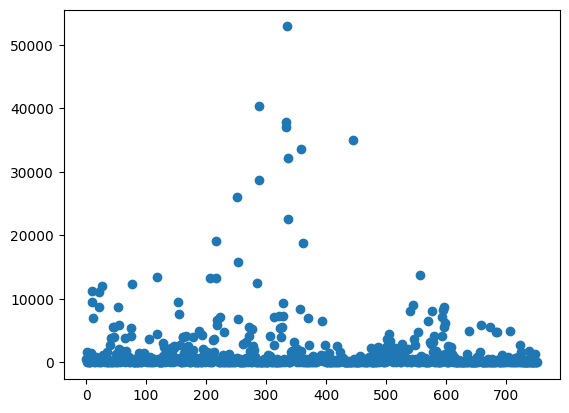

In [38]:
#Diagrama de dispersion para el tiempo de espera
x_valu = pd.Series(range(0,len(callByOperation)))

plt.scatter(x_valu, callByOperation['tiempo_espera'])

In [39]:
print(np.percentile(callByOperation['tiempo_espera'], [90, 95, 99]))

[ 3992.    7093.8  27322.44]


**Conclusion:** 
- El 10% tiene un tiempo de espera superior a 3992.
- el 5% de los operadores tiene un tiempo de espera mayor a 7093
- El 1% de los operadores tiene un tiempo de espera mayor a 27322.44

Se define que cada operador que tarde mas de 3993 segundos en espera en una sola llamada, se considerara un operador ineficaz

In [40]:
#Definimos la proporcion entre el tiempo de espera por llamada de cada operador
callByOperation['proporcion'] = callByOperation['tiempo_espera'] / callByOperation['cantidad_llamadas']

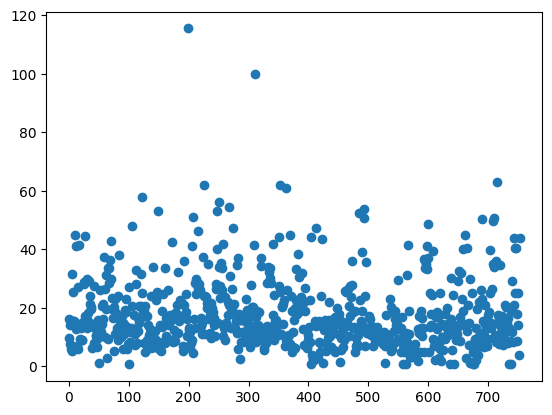

In [41]:
#Diagrama de dispersion para el tiempo de espera proporcion
valu = pd.Series(range(0,len(callByOperation)))

plt.scatter(valu, callByOperation['proporcion'])

In [42]:
print(np.percentile(callByOperation['proporcion'], [90, 95, 99]))

[33.67333333 41.5        55.4       ]


**Conclusión:** el 5% de los operadores tardan mas de 41.5 segundos en responder, por lo que tomaremos ese percentil para definir que un operador ineficaz es el que se demora mas de 41 segundos en responder cada llamada.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Has identificado operadores ineficaces de manera clara utilizando percentiles, lo cual es un enfoque adecuado. La definición de umbrales, como los 3993 segundos y los 41 segundos por llamada, está bien fundamentada. Buen uso de gráficos para ilustrar la distribución del tiempo de espera.

Considera explicar brevemente cómo manejarás los valores nulos en `internal` y `operator_id` o justificar si decides no hacerlo. ¡Gran trabajo en esta sección!
</div>


## Hipotesis

### "Los operadores con mas cantidad de llamadas contestadas tienden a realizar menos llamadas"

In [53]:
#Cantidad de llamadas contestadas y cantidad de llamadas realizadas
llamadas_contestadas = (
    call_in_conts.drop(['user_id', 'date', 'direction', 'internal', 'is_missed_call', 'total_call_duration', 'tiempo_espera'], axis=1)
    .groupby('operator_id', as_index=False)
    .agg({'calls_count': 'sum'})
)

llamadas_contestadas.columns = ['operador_id', 'cant_llamadas_conts']

# llamadas realizadas
llamadas_realizadas = (
    call_out.drop(['user_id', 'date', 'direction', 'internal', 'is_missed_call', 'total_call_duration', 'tiempo_espera'], axis=1)
    .groupby('operator_id', as_index=False)
    .agg({'calls_count': 'sum'})
)

llamadas_realizadas.columns = ['operador_id', 'cant_llamadas_realiz']

#Unimos los df

df_unido = llamadas_contestadas.merge(llamadas_realizadas, on='operador_id')
df_unido.head(2)

,operador_id,cant_llamadas_conts,cant_llamadas_realiz
0,879896.0,58,870
1,879898.0,104,7201


In [56]:
# Calcular la correlación de Pearson 
correlation, p_value = pearsonr(df_unido['cant_llamadas_conts'], df_unido['cant_llamadas_realiz']) 
print(f"Coeficiente de correlación de Pearson: {correlation}") 
print(f"Valor p: {p_value}") 

# Interpretación de los resultados 
if p_value < 0.05: print("Existe una relación significativa entre la cantidad de llamadas contestadas y las llamadas realizadas.") 
else: print("No hay evidencia suficiente para concluir que existe una relación significativa.")

Coeficiente de correlación de Pearson: 0.19787910332745287
Valor p: 3.3770230475592894e-06
Existe una relación significativa entre la cantidad de llamadas contestadas y las llamadas realizadas.


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Has implementado correctamente la prueba de hipótesis utilizando la correlación de Pearson para evaluar la relación entre las llamadas contestadas y las llamadas realizadas por operador. El coeficiente de correlación de 0.198 y el valor p muy bajo indican una relación significativa, aunque la correlación es débil. Sería útil interpretar el posible significado de esta relación débil: ¿podría haber otros factores influyendo en esta dinámica? Además, podrías considerar explorar más contextos o hipótesis adicionales para fortalecer el análisis.
</div>


### "Los operadores con tiempos de espera más largos tienden a tener más llamadas perdidas.

In [57]:
#Calcular tiempo de espera por operador
tiempo_espera_operador = (
    call_in_conts.drop(['user_id', 'date', 'direction', 'internal', 'is_missed_call', 'total_call_duration', 'calls_count'], axis=1)
    .groupby('operator_id', as_index=False)
    .agg({'tiempo_espera': 'sum'})
)

tiempo_espera_operador.columns = ['operador_id', 'tiempo_espera']

# Calcular cantidad de llamadas perdidas por operador
#Filtrar el dataset
call_in_perd = call_in[call_in['is_missed_call'] == True]
llamadas_per_operador = (
    call_in_perd.drop(['user_id', 'date', 'direction', 'internal', 'is_missed_call', 'total_call_duration', 'tiempo_espera'], axis=1)
    .groupby('operator_id', as_index=False)
    .agg({'calls_count': 'sum'})
)

llamadas_per_operador.columns = ['operador_id', 'cant_llamadas_per']


In [62]:
#Unir los df
df_uni = tiempo_espera_operador.merge(llamadas_per_operador, on='operador_id')


In [63]:
# Calcular la correlación de Pearson 
correlation, p_value = pearsonr(df_uni['tiempo_espera'], df_uni['cant_llamadas_per']) 
print(f"Coeficiente de correlación de Pearson: {correlation}") 
print(f"Valor p: {p_value}") 

# Interpretación de los resultados 
if p_value < 0.05: print("Existe una relación significativa entre el tiempo de espera y el número de llamadas perdidas.") 
else: print("No hay evidencia suficiente para concluir que existe una relación significativa.")

Coeficiente de correlación de Pearson: 0.36677010028080115
Valor p: 5.443777667528006e-09
Existe una relación significativa entre el tiempo de espera y el número de llamadas perdidas.


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

La segunda hipótesis está bien respaldada con una correlación positiva moderada (0.367) y un valor p extremadamente bajo, indicando una relación significativa entre el tiempo de espera y las llamadas perdidas. Este hallazgo es relevante y podría tener importantes implicaciones operativas. Te sugiero profundizar en cómo esta relación podría guiar las acciones correctivas, como la mejora de la eficiencia de los operadores. También podrías incluir una breve discusión sobre la variabilidad y si ciertas condiciones pueden amplificar esta relación.
</div>


## Conclusiones

- Determinamos que los operadores con mas de 15 llamadas perdidas, se consideraran ineficaces.
- Se define que cada operador que tarde mas de 3993 segundos en espera en una sola llamada, se considerara un operador ineficaz.
- El 5% de los operadores tardan mas de 41.5 segundos en responder, por lo que tomaremos ese percentil para definir que un operador ineficaz es el que se demora mas de 41 segundos en tiempo de espera de cada llamada.

Hipotesis:

Si existe una relacion significativa en las dos hipotesis.
- Los operadores con mas cantidad de llamadas contestadas tienden a realizar menos llamadas.
- Los operadores con tiempos de espera más largos tienden a tener más llamadas perdidas

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

<b>Atención</b> ⚠️ - Para mejorar la claridad y profundidad de tus conclusiones finales, considera las siguientes pautas:

<ul>
    <li><b>Resumen de los Hallazgos Clave:</b> Incluye brevemente tus descubrimientos más importantes.</li>
    <li><b>Impacto de tus Elecciones de Procesamiento de Datos:</b> Reflexiona sobre cómo tus decisiones influyeron en los resultados.</li>
    <li><b>Relación con los Objetivos Iniciales:</b> Vincula tus hallazgos con los objetivos del proyecto.</li>
    <li><b>Relevancia de los Hallazgos:</b> Discute la importancia de tus resultados para la empresa o usuarios.</li>
    <li><b>Sugerencias y Recomendaciones:</b> Ofrece cualquier consejo basado en tus análisis.</li>
    <li><b>Reflexiones Finales:</b> Concluye con tus pensamientos finales y aprendizajes del proyecto.</li>
</ul>

Recuerda que una conclusión efectiva resume tus hallazgos y proporciona insights y reflexiones sobre su impacto y relevancia. ¡Sigue así y éxito en la etapa final!
</div>

# Comentario del Revisor

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Excelente trabajo en tu análisis detallado del desempeño de los operadores en el servicio de telefonía virtual CallMeMaybe! Tu proyecto abarca un enfoque integral desde el preprocesamiento de datos hasta la comprobación de hipótesis, lo cual es crucial para identificar la ineficacia operativa.

### Puntos fuertes:
- **Objetivo claro**: Has definido claramente qué se considera un operador ineficaz y los criterios que utilizas, como llamadas perdidas y tiempos de espera.
- **Preprocesamiento exhaustivo**: Identificaste y manejaste duplicados y convertiste las fechas correctamente, lo que muestra un buen manejo del preprocesamiento.
- **Análisis descriptivo y visualizaciones**: Los histogramas y gráficos de dispersión son útiles para visualizar distribuciones y entender patrones en los datos.
- **Uso de estadística**: Aplicaste adecuadamente la correlación de Pearson para evaluar las relaciones entre variables importantes, y proporcionaste interpretaciones claras.

### Áreas de mejora:
1. **Claridad y estructura**: Puedes mejorar la estructura del análisis dividiendo el contenido en secciones más detalladas con subtítulos claros para facilitar la lectura. Por ejemplo, podrías tener una sección dedicada a “Identificación de operadores ineficaces” y otra a “Pruebas de hipótesis”.
2. **Explicación de criterios**: Aunque defines los operadores ineficaces basándote en ciertos umbrales (15 llamadas perdidas, 3993 segundos de espera, y 41 segundos de tiempo de respuesta), podrías justificar mejor estos umbrales explicando por qué fueron seleccionados o cómo afectan el desempeño general.
3. **Interpretación de resultados**: Aunque el uso de correlaciones es correcto, sería útil profundizar en la interpretación de los resultados, especialmente si la relación encontrada es débil o moderada. ¿Qué implicaciones tiene para la operativa de la empresa?
4. **Limitaciones y recomendaciones**: Considera agregar una sección sobre las limitaciones del estudio, como la disponibilidad de datos solo para un día en el dataset principal o las posibles variaciones estacionales en el volumen de llamadas. También podrías ofrecer recomendaciones prácticas para mejorar la eficiencia de los operadores.

### Sugerencias adicionales:
- **Optimización del código**: Podrías limpiar el código eliminando líneas repetitivas o comentarios que ya no sean necesarios, para mantenerlo más legible.
- **Ampliar el análisis**: Si es posible, podrías realizar un análisis de tendencias temporales para observar cómo cambian los patrones de llamadas a lo largo del tiempo o evaluar si hay operadores que consistentemente son ineficaces.

En general, tu proyecto muestra un análisis sólido y bien pensado. ¡Buen trabajo, y sigue adelante con esta excelente metodología analítica!
</div>
